<a href="https://colab.research.google.com/github/FajarKKP/ML-DL_related_project/blob/main/SIBI_ImageDataGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import sklearn
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report 
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives, Precision, Recall, Accuracy, AUC

In [2]:
#Import data from Gdrive
# data_dir = '/content/drive/MyDrive/Dataset_pakai'


# Initialize batch size and image size
batch_size = 32
image_size = (224,224)
cl_names= ["A","B","C","D","E","F","G","H","I","K",
           "L","M","N","O","P","Q","R","S","T","U",
           "V","W","X","Y",]

In [6]:
#For Augmentation
train_datagen = ImageDataGenerator(
                    rotation_range=10,
                    horizontal_flip=True)
 
test_datagen = ImageDataGenerator()

In [7]:

train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/testing_folder/train', 
        target_size=image_size, 
        batch_size=batch_size,
        shuffle = True,
        class_mode='sparse',
        classes=cl_names)
 
val_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/testing_folder/val', 
        target_size=image_size, 
        batch_size=batch_size,
        # shuffle = True,
        class_mode='sparse',
        classes=cl_names)

test_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/testing_folder/test', 
        target_size=image_size, 
        batch_size=batch_size,
        class_mode='sparse',
        classes=cl_names)

Found 9600 images belonging to 24 classes.
Found 1200 images belonging to 24 classes.
Found 1200 images belonging to 24 classes.


In [8]:
# Import the EfficientNet model
eff_model1 = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, input_shape=(224,224,3))
print(type(eff_model1))
eff_model1.summary()

16719872/16705208 [==============================] - 0s 0us/step
<class 'keras.engine.functional.Functional'>
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                          

In [9]:
# Freeze the EfficientNet, then set the dropout rate we will use for our model
eff_model1.trainable = False
dropout_rate = 0.2 #@param {type:"slider", min:0, max:1, step:0.1}

In [10]:
# Create a new model, combining the EfficientNet and new output layer with 24 output class

model = models.Sequential()
model.add(eff_model1)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))

model.add(layers.Dense(24, activation="softmax", name="fc_out"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 24)                30744     
                                                                 
Total params: 4,080,315
Trainable params: 30,744
Non-trainable params: 4,049,571
_________________________________________________________________


In [11]:
# Train model
epochs = 50

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epochs, logs={}):
    if(logs.get('accuracy')>0.98):
      print("\n Good enough, its above 98%")
      self.model.stop_training=True
callbacks = myCallback()

# early_stopping = keras.callbacks.EarlyStopping(
#     monitor="accuracy",
#     patience=5,
  
# )


model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy", #"sparse_categorical_crossentropy" if label is in integer
    metrics=['accuracy'],
)
final_model = model.fit(train_generator, epochs=epochs, callbacks=[callbacks], validation_data=val_generator)

Epoch 1/50
300/300 [==============================] - 2865s 10s/step - loss: 2.0795 - accuracy: 0.5468 - val_loss: 0.5630 - val_accuracy: 0.8425
Epoch 2/50
300/300 [==============================] - 609s 2s/step - loss: 0.5923 - accuracy: 0.8258 - val_loss: 0.2985 - val_accuracy: 0.9125
Epoch 3/50
300/300 [==============================] - 607s 2s/step - loss: 0.3883 - accuracy: 0.8789 - val_loss: 0.2694 - val_accuracy: 0.9192
Epoch 4/50
300/300 [==============================] - 614s 2s/step - loss: 0.3040 - accuracy: 0.9017 - val_loss: 0.1239 - val_accuracy: 0.9642
Epoch 5/50
300/300 [==============================] - 634s 2s/step - loss: 0.2251 - accuracy: 0.9293 - val_loss: 0.0969 - val_accuracy: 0.9725
Epoch 6/50
300/300 [==============================] - 636s 2s/step - loss: 0.2124 - accuracy: 0.9322 - val_loss: 0.1179 - val_accuracy: 0.9675
Epoch 7/50
300/300 [==============================] - 627s 2s/step - loss: 0.1932 - accuracy: 0.9401 - val_loss: 0.1984 - val_accuracy: 0.94

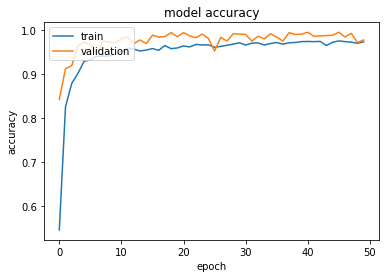

In [12]:
def plot_hist(final_model):
    plt.plot(final_model.history["accuracy"])
    plt.plot(final_model.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(final_model)

In [13]:
model.save('/content/drive/MyDrive/Hasil_model_EfficientNet/final_model_generator2.h5')
model.save('/content/drive/MyDrive/Hasil_model_EfficientNet/final_model_generator2.hdf5')

In [15]:
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

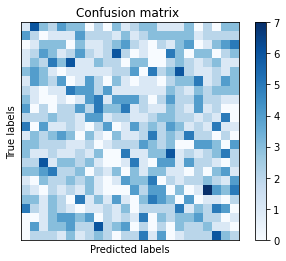

[[1 6 3 2 4 3 3 0 2 0 3 1 2 3 3 1 1 1 3 0 2 0 3 3]
 [4 2 0 1 1 1 4 2 2 2 1 3 1 2 3 3 3 3 3 1 2 2 2 2]
 [0 1 3 3 3 0 3 1 1 2 3 4 2 1 0 2 1 3 4 0 1 3 4 5]
 [1 2 4 3 1 2 4 2 1 2 6 2 0 1 0 0 5 3 0 3 3 0 2 3]
 [1 3 2 5 3 6 1 1 3 2 2 0 3 3 0 0 2 3 2 1 2 3 1 1]
 [3 4 3 1 0 1 1 1 1 1 2 2 4 0 5 2 3 6 2 1 1 2 1 3]
 [1 4 3 2 4 0 1 4 2 0 3 1 0 1 1 0 2 3 3 5 1 2 4 3]
 [2 1 0 1 1 5 4 4 2 4 1 1 1 1 1 1 3 2 1 3 2 3 3 3]
 [3 1 0 0 1 0 1 4 5 1 4 4 4 2 0 2 4 2 2 4 2 2 1 1]
 [4 0 2 0 2 2 4 2 5 3 3 5 1 2 1 1 3 2 1 4 1 2 0 0]
 [2 2 2 3 2 2 1 4 4 1 2 2 1 1 2 3 3 2 2 1 2 1 5 0]
 [5 0 4 1 1 2 1 0 2 4 0 1 4 2 3 2 4 3 1 2 1 5 1 1]
 [1 3 2 3 4 3 0 3 1 0 3 1 1 2 5 2 3 2 5 2 2 0 2 0]
 [3 3 2 2 2 1 1 2 0 1 2 2 2 4 3 2 3 0 0 4 4 3 0 4]
 [3 1 1 2 1 1 2 1 3 0 0 5 1 1 3 3 6 1 2 1 2 3 5 2]
 [2 2 6 1 3 3 2 3 1 0 0 1 5 1 0 4 4 1 4 2 2 1 0 2]
 [3 3 4 5 2 2 3 0 2 1 3 0 3 1 3 3 1 1 0 2 0 3 4 1]
 [1 0 3 2 2 3 2 3 1 0 1 4 3 3 5 0 2 1 2 2 3 2 1 4]
 [2 1 0 2 1 2 1 3 1 0 0 0 4 2 4 4 0 3 0 1 7 4 3 5]
 [3 3 1 3 2 0 5 1 3 1 4 1 0 3 5

In [21]:
# Confusion matrix
cm =confusion_matrix(test_generator.classes, y_pred)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

print(cm)

In [20]:
# Classification report
cr = classification_report(test_generator.classes, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.02      0.02      0.02        50
           1       0.04      0.04      0.04        50
           2       0.06      0.06      0.06        50
           3       0.06      0.06      0.06        50
           4       0.06      0.06      0.06        50
           5       0.02      0.02      0.02        50
           6       0.02      0.02      0.02        50
           7       0.08      0.08      0.08        50
           8       0.10      0.10      0.10        50
           9       0.09      0.06      0.07        50
          10       0.04      0.04      0.04        50
          11       0.02      0.02      0.02        50
          12       0.02      0.02      0.02        50
          13       0.08      0.08      0.08        50
          14       0.06      0.06      0.06        50
          15       0.08      0.08      0.08        50
          16       0.02      0.02      0.02        50
          17       0.02    